## Michał Wiśniewski 418486

**Problem 2c (Squaring the histogram).** In this problem, we again want to sample with known probabilities $p_1,\ldots,p_n$, but this time we make no assumptions on $p_i$. Consider the following algorithm:
   * Let $V$ be the mean of $p_i$, i.e. $V=\frac{1}{n}$.
   * Create $n$ buckets, each with volume $V$, put each $p_i$ into a separate bucket.
   * Until there exists a bucket $A$ that is not full, find a bucket $B$ that overflows, and trasfer probability from $B$ to $A$ until $A$ is exactly full

Show that:
   * This algorithm always ends.
   * When it ends, each bucket contains pieces of exactly two $p_i$'s.

How to use the result of this algorithm to sample with probabilities $p_i$. Argue that your algorithm is correct and implement it. The sampling part should be *vectorized*. Use this algorithm to sample birthdates again, and test its efficiency.

# Rozwiązanie

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
data = np.loadtxt('./lab1/us_births_69_88.csv', skiprows=1, delimiter=',', dtype=int)

## Kubełkowanie

In [3]:
def underflows(frac, n):
    return frac < 1/n

def overflows(frac, n):
    return frac > 1/n

def bucketize(counts):
    n = len(counts)
    sum_counts = np.sum(counts)
    
    buckets_volume = [c / sum_counts for c in counts]
    buckets_presence = [[i] for i in range(n)]
    probabilities = [bv for bv in buckets_volume]

    overflowing = {i for i, frac in enumerate(buckets_volume) if overflows(frac, n)}
    underflowing = {i for i, frac in enumerate(buckets_volume) if underflows(frac, n)}

    # Tak długo aż istnieje niepełny kubełek i przelewający się kubełek.
    while len(overflowing) > 0 and len(underflowing) > 0:
        underflow_idx = underflowing.pop()
        overflow_idx = overflowing.pop()
        probabilities[underflow_idx] = buckets_volume[underflow_idx]
        
        diff = 1/n - buckets_volume[underflow_idx]
        buckets_volume[underflow_idx] = 1/n
        buckets_volume[overflow_idx] = buckets_volume[overflow_idx]-diff
        
        buckets_presence[underflow_idx].append(overflow_idx)

        if underflows(buckets_volume[overflow_idx], n):
            underflowing.add(overflow_idx)
        elif overflows(buckets_volume[overflow_idx], n):
            overflowing.add(overflow_idx)
    
    for bucket in buckets_presence:
        if len(bucket) == 1:
            # Jeśli w kubełku jest tylko jeden dzień, to dodajemy
            # na końcu -1, i tak nigdy jej nie wylosujemy
            bucket.append(-1) 
    probabilities = np.array(probabilities) * n
    buckets_presence = np.array(buckets_presence)
    
    return probabilities, buckets_presence

### Wytłumaczenie
Ten algorytm działa tak, że bierze niedopełniony kubełek i nadpełniony kubełek i przelewa z nadpełnionego to niedopełnionego, aby w niedopełnionym była idealna objętość.  
W takim razie, jeśli bierzemy tylko niedopełnione i nadpełnione kubełki to mamy gwarancję, że jeśli któryś z kubełkow będzie miał oczekiwaną objętość (będzie pełny) to go już ponownie nie weźmiemy.  
Kubełek który przed operacją był nadpełniony, teraz może być nadpełniony, pełny lub niedopełniony. Czyli po każdej operacji albo zmniejszamy ilość niedopełnionych kubełków albo pozostaje ona równa (gdy kubełek początkowo nadpełniony zamienia się w niedopełniony). To pokazuje, że każdy kubełek może być dopełniony przez jakiś inny kubełek dokładnie raz (bo wtedy, po dopełnieniu, jest już pełny). Z tego wynika, że algorytm się skończy, ponieważ dopełniamy kubełki, a każdy kubełek dopełniamy tylko raz, a jest ich skończona ilość. Z tego również wynika, że w każdym kubełku będą części z co najwyżej 2 kubełkow, bo będąc kubełkiem niedopełnionym mamy tylko swoją część, a będąc dopełnionym dostajemy część od innego kubełka i już jesteśmy pełni i nie dostaniemy więcej części.

## Znajdowanie powtórek

In [4]:
def count_runs_until_repeat_vectorized(days):
    s = set()
    results = []
    for day in days:
        if day in s:
            results.append(len(s))
            s = set()
        else:
            s.add(day)
    return results

## Samplowanie

In [5]:
def sample(counts, n):    
    probabilities, buckets = bucketize(counts)
    
    days = np.random.randint(0, len(buckets), size=n)
    generated_probabilities = np.random.uniform(0, 1, size=n)
    
    data = np.where(generated_probabilities <= probabilities[days], 
                    buckets[days, 0],
                    buckets[days, 1])
    return data

## Test Samplowania

In [6]:
counts = [1, 6, 3]
N = 1000000
sampling = sample(counts, N)

(array([100020.,      0.,      0.,      0.,      0., 599651.,      0.,
             0.,      0., 300329.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

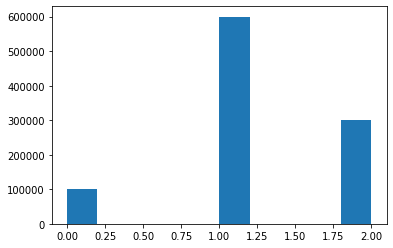

In [7]:
plt.hist(sampling)

In [8]:
counts = [4, 4, 4, 4]
N = 1000000
sampling = sample(counts, N)

(array([249692.,      0.,      0., 250411.,      0.,      0., 250356.,
             0.,      0., 249541.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

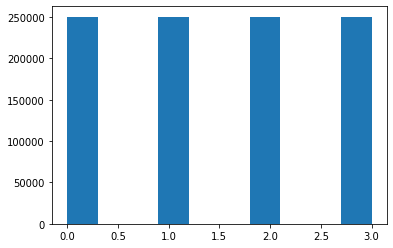

In [9]:
plt.hist(sampling)

## Użycie samplowania z kubełkowaniem na danych z pliku

In [10]:
%%time
counts = data[:, 2]
N = 2500000
sampling = sample(counts, N)

CPU times: user 55.2 ms, sys: 15.6 ms, total: 70.9 ms
Wall time: 70.1 ms


In [11]:
%%time
runs = count_runs_until_repeat_vectorized(sampling)
print('Ilość kolizji:', len(runs))

Ilość kolizji: 101682
CPU times: user 441 ms, sys: 0 ns, total: 441 ms
Wall time: 440 ms


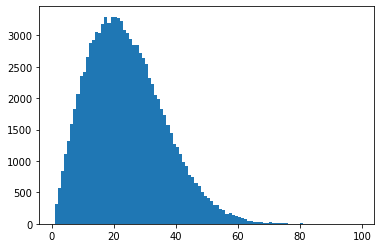

In [12]:
plt.hist(runs, bins=range(1, 100));

In [13]:
np.average(runs)

23.586239452410457